<a href="https://colab.research.google.com/github/RobDrie/IT-Tools-Spark/blob/main/Spark_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=ed397c86fa737abec567ab0d2d745a34c8a8ad4b6e162bf0e167089419a66684
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [1]:
import pyspark
import seaborn as sns
from pyspark.sql.functions import year, month, dayofweek, col, split
from pyspark.sql.functions import weekofyear
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col, datediff, lit, floor, when
from pyspark.sql import functions as F
from pyspark.sql.functions import avg
from pyspark.sql.functions import desc

In [2]:
spark = pyspark.sql.SparkSession.builder.appName('Session1').getOrCreate()

24/01/19 17:26:49 WARN Utils: Your hostname, gonem-rogzephyrusg15ga503qmga503qm resolves to a loopback address: 127.0.1.1; using 10.10.255.105 instead (on interface wlp4s0)
24/01/19 17:26:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/19 17:26:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load & Process gas price data with Spark
# * Download 2019 to 2023 gas price data
* Download gas Stations file & Services file (2022 versions)

In [ ]:
!git clone https://github.com/rvm-courses/GasPrices

Cloning into 'GasPrices'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 143 (delta 3), reused 0 (delta 0), pack-reused 124
Receiving objects: 100% (143/143), 619.51 MiB | 36.71 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Updating files: 100% (40/40), done.


## Data Preparation - step 1
* Read and merge all gas files
* Split date in year, month, week of the year
* Prepare latitude & longitude for mapping (divide by the right power of 10)
* Make data available as a table in order to be able to use Spark S

In [3]:
def price_download(year_list):
  prices_df = None

  for year in year_list:
    file_path = f'GasPrices/Prix{year}.csv.gz'
    current_df = spark.read.option("header", "False").option('delimiter', ';').csv(file_path)

    if prices_df is None:
      prices_df = current_df
    else:
      prices_df = prices_df.union(current_df)

  return prices_df

In [4]:
# Download price data for 2019 to 2023
year_list = ['2019', '2020', '2021', '2022S1', '2022S2']
prices_df = price_download(year_list)

file_path = 'GasPrices/Stations2022.csv.gz'
stations_df = spark.read.option("header", "False").option('delimiter', '|').csv(file_path)

file_path = 'GasPrices/Services2022.csv.gz'
services_df = spark.read.option("header", "False").option('delimiter', '|').csv(file_path)

### Variable definitions
* id_pdv = points of sales
* cp = zip code
* pop = type of population
* latitude
* longitude
* date
* id carburant = gas id
* nom carburant = gas label
* prix = price in millieuros

In [5]:
# Set the column headers for price dataframe
columns_mapping = {
    'prices_df': {'old': prices_df.columns, 'new': ['id_pdv', 'cp', 'pop', 'latitude', 'longitude', 'date', 'id_carburant', 'nom_carburant', 'prix']},
    'stations_df': {'old': stations_df.columns, 'new': ['id_pdv', 'cp', 'pop', 'latitude', 'longitude', 'adresse', 'vile']},
    'services_df': {'old': services_df.columns, 'new': ['id_pdv', 'cp', 'pop', 'latitude', 'longitude', 'services']}
}

for df_name, mapping in columns_mapping.items():
    for new_name, old_name in zip(mapping['new'], mapping['old']):
        globals()[df_name] = globals()[df_name].withColumnRenamed(f'{old_name}', f'{new_name}')

### Split prices date in year, month, day, and week of the year

In [6]:
# Split the date column into date and time to extract the dates
split_datetime = split(prices_df['date'], 'T')
prices_df = prices_df.withColumn('Date', split_datetime.getItem(0))
split_date = split(prices_df['Date'], '-')

# Add columns year, month, day, and weekofyear
prices_df = prices_df.withColumn('Year', split_date.getItem(0))
prices_df = prices_df.withColumn('Month', split_date.getItem(1))
prices_df = prices_df.withColumn('Day', split_date.getItem(2))
prices_df = prices_df.withColumn('WeekOfYear', weekofyear(prices_df['Date']))

In [7]:
# prices_df.filter("continuous_week_number =  0  AND id_carburant = 1").show(5)

In [8]:
from pyspark.sql.functions import expr, to_date, year as year_col, date_sub

def calculate_continuous_week_number(df, start_date, date_column, start_week_number=1):
    # Convert the date column to a date type
    df = df.withColumn(date_column, to_date(col(date_column)))
    start_date = to_date(lit(start_date))
    start_date = date_sub(start_date, dayofweek(start_date) - 2)

    # Calculate the difference in days and then convert to weeks
    days_diff = datediff(df[date_column], start_date)
    weeks_diff = (days_diff / 7).cast('int')

    return df.withColumn("continuous_week_number", weeks_diff + 1)

start_date = "2019-01-01"
prices_df = calculate_continuous_week_number(prices_df, start_date, "Date")
prices_df.filter("continuous_week_number =  0  AND id_carburant = 3").show(15)
prices_df.filter("continuous_week_number =  1  AND id_carburant = 3").show(15)
prices_df.filter("continuous_week_number =  53  AND id_carburant = 3").show(15)
prices_df.filter("continuous_week_number =  156 AND id_carburant = 3").show(15)
prices_df.filter("continuous_week_number =  157 AND id_carburant = 3").show(15)

+------+---+---+--------+---------+----+------------+-------------+----+----+-----+---+----------+----------------------+
|id_pdv| cp|pop|latitude|longitude|Date|id_carburant|nom_carburant|prix|Year|Month|Day|WeekOfYear|continuous_week_number|
+------+---+---+--------+---------+----+------------+-------------+----+----+-----+---+----------+----------------------+
+------+---+---+--------+---------+----+------------+-------------+----+----+-----+---+----------+----------------------+

+-------+-----+---+---------------+---------------+----------+------------+-------------+----+----+-----+---+----------+----------------------+
| id_pdv|   cp|pop|       latitude|      longitude|      Date|id_carburant|nom_carburant|prix|Year|Month|Day|WeekOfYear|continuous_week_number|
+-------+-----+---+---------------+---------------+----------+------------+-------------+----+----+-----+---+----------+----------------------+
|1100007|01100|  R|        4624966|         564134|2019-01-01|           3|    

+-------+-----+---+-------------+-------------+----------+------------+-------------+----+----+-----+---+----------+----------------------+
| id_pdv|   cp|pop|     latitude|    longitude|      Date|id_carburant|nom_carburant|prix|Year|Month|Day|WeekOfYear|continuous_week_number|
+-------+-----+---+-------------+-------------+----------+------------+-------------+----+----+-----+---+----------+----------------------+
|1000012|01000|  R|      4620100|       520000|2021-12-20|           3|          E85| 699|2021|   12| 20|        51|                   156|
|1000012|01000|  R|      4620100|       520000|2021-12-21|           3|          E85| 699|2021|   12| 21|        51|                   156|
|1000012|01000|  R|      4620100|       520000|2021-12-22|           3|          E85| 699|2021|   12| 22|        51|                   156|
|1000012|01000|  R|      4620100|       520000|2021-12-23|           3|          E85| 699|2021|   12| 23|        51|                   156|
|1000012|01000|  R| 

+-------+-----+---+-------------+-------------+----------+------------+-------------+----+----+-----+---+----------+----------------------+
| id_pdv|   cp|pop|     latitude|    longitude|      Date|id_carburant|nom_carburant|prix|Year|Month|Day|WeekOfYear|continuous_week_number|
+-------+-----+---+-------------+-------------+----------+------------+-------------+----+----+-----+---+----------+----------------------+
|1000012|01000|  R|      4620100|       520000|2021-12-27|           3|          E85| 699|2021|   12| 27|        52|                   157|
|1000012|01000|  R|      4620100|       520000|2021-12-28|           3|          E85| 699|2021|   12| 28|        52|                   157|
|1000012|01000|  R|      4620100|       520000|2021-12-29|           3|          E85| 699|2021|   12| 29|        52|                   157|
|1000012|01000|  R|      4620100|       520000|2021-12-30|           3|          E85| 719|2021|   12| 30|        52|                   157|
|1000012|01000|  R| 

In [9]:
prices_df.filter("continuous_week_number =  158 AND id_carburant = 3").show(15)

+-------+-----+---+-------------+-------------+----------+------------+-------------+-----+----+-----+---+----------+----------------------+
| id_pdv|   cp|pop|     latitude|    longitude|      Date|id_carburant|nom_carburant| prix|Year|Month|Day|WeekOfYear|continuous_week_number|
+-------+-----+---+-------------+-------------+----------+------------+-------------+-----+----+-----+---+----------+----------------------+
|1000012|01000|  R|      4620100|       520000|2022-01-03|           3|          E85|0.739|2022|   01| 03|         1|                   158|
|1000012|01000|  R|      4620100|       520000|2022-01-04|           3|          E85|0.739|2022|   01| 04|         1|                   158|
|1000012|01000|  R|      4620100|       520000|2022-01-05|           3|          E85|0.739|2022|   01| 05|         1|                   158|
|1000012|01000|  R|      4620100|       520000|2022-01-06|           3|          E85|0.739|2022|   01| 06|         1|                   158|
|1000012|0100

In [10]:
# # Filter out the Null observations
# prices_df2 =  prices_df.withColumn('Date2', col("date").cast("date"))
# prices_df2 = prices_df2.filter(col("Date2").isNotNull())

# # Create reference for first week
# reference_date = spark.createDataFrame([("2019-01-01",)], ["reference_date"])
# reference_date = reference_date.withColumn("reference_date", col("reference_date").cast("date"))
# reference_week_number = lit(1)

# # Calculate the week numbers based on the reference
# prices_df2 = prices_df2.crossJoin(reference_date)
# df = prices_df2.withColumn("continuous_week_number", floor(datediff(col("date"), col("reference_date")) / 7) + reference_week_number)
# df.filter("continuous_week_number =  53 AND id_carburant = 1").show(5)
# df.filter("continuous_week_number =  157 AND id_carburant = 1").show(5)


In [11]:
# from pyspark.sql.window import Window
# from pyspark.sql import functions as F
# window_spec = Window.orderBy("Date")

# # Calculate the week index using the dense rank function
# df = prices_df2.withColumn("Week_Index", F.dense_rank().over(window_spec) - 1)

In [12]:
# from pyspark.sql.functions import col, unix_timestamp, from_unixtime, weekofyear, datediff
# df = prices_df.withColumn("date", col("date").cast("date"))

# # Convert the 'date' column to DateType
# df = df.withColumn("date", col("date").cast("date"))

# # Find the minimum date in the DataFrame
# min_date = df.agg({"date": "min"}).collect()[0][0]

# # Calculate the difference in days from the minimum date using datediff
# df = df.withColumn("WeekOfYear", weekofyear(datediff(col("date"), min_date.cast("date"))) + 1)

### Prepare latitude & longitude for mapping (Divide by the right power of 10) to map the latitude & longitude on a [0,1] scale, we identity two different constants

In [13]:
# prices_df.printSchema()
# services_df.printSchema()
# stations_df.printSchema()
from pyspark.sql.types import DoubleType

prices_df = prices_df.withColumn("latitude_int", col("latitude").cast("Integer"))
prices_df = prices_df.withColumn("longitude_int", col("longitude").cast("Integer"))
prices_df = prices_df.withColumn("prix_int", col("prix").cast(DoubleType()))

services_df = services_df.withColumn("latitude_int", col("latitude").cast("Integer"))
services_df = services_df.withColumn("longitude_int", col("longitude").cast("Integer"))

stations_df = services_df.withColumn("latitude_int", col("latitude").cast("Integer"))
stations_df = services_df.withColumn("longitude_int", col("longitude").cast("Integer"))

# prices_df.printSchema()
# services_df.printSchema()
# stations_df.printSchema()

In [14]:
division_constant_latitude = 10**7
division_constant_longitude = 10**6

dataframes = [prices_df, stations_df, services_df]

for i in range(len(dataframes)):
    dataframes[i] = dataframes[i].withColumn('latitude_adj', col('latitude_int') / division_constant_latitude)
    dataframes[i] = dataframes[i].withColumn('longitude_adj', col('longitude_int') / division_constant_longitude)

prices_df, stations_df, services_df = dataframes

In [15]:
# Check if all columns contain values or some have NULL (missing) value
rows_null = prices_df.where(
    col("prix_int").isNull() |
    col("id_carburant").isNull() |
    col("Year").isNull()
)
rows_null.show(10)

+-------+-----+---+-------------+-------------+----+------------+-------------+----+----+-----+----+----------+----------------------+------------+-------------+--------+------------+-------------+
| id_pdv|   cp|pop|     latitude|    longitude|Date|id_carburant|nom_carburant|prix|Year|Month| Day|WeekOfYear|continuous_week_number|latitude_int|longitude_int|prix_int|latitude_adj|longitude_adj|
+-------+-----+---+-------------+-------------+----+------------+-------------+----+----+-----+----+----------+----------------------+------------+-------------+--------+------------+-------------+
|1000005|01000|  R|4620093.59235|519942.024022|NULL|        NULL|         NULL|NULL|NULL| NULL|NULL|      NULL|                  NULL|     4620093|       519942|    NULL|   0.4620093|     0.519942|
|1000006|01000|  R|      4620754|       523758|NULL|        NULL|         NULL|NULL|NULL| NULL|NULL|      NULL|                  NULL|     4620754|       523758|    NULL|   0.4620754|     0.523758|
|1000010|0

In [16]:
# Delete missing values
prices_df_without_null = prices_df.na.drop()

In [17]:
# Prices in the dataframes 2019-2021 are given in mili-euros, whereas the prices
# in the dataframes 2022S1 and 2022S2 are given in euros. Divide by 1000 to get
# the same scale

division_constant_prix = 1000
condition = (col("Year") != "2022")
prices_df_without_null_adj = prices_df_without_null.withColumn('prix_adj', when(condition, col('prix_int') / division_constant_prix).otherwise(col('prix_int')))

ordered_df = prices_df_without_null_adj.orderBy(desc("prix_adj"))
ordered_df.show()

+--------+-----+---+---------------+----------------+----------+------------+-------------+-----+----+-----+---+----------+----------------------+------------+-------------+--------+------------+-------------+--------+
|  id_pdv|   cp|pop|       latitude|       longitude|      Date|id_carburant|nom_carburant| prix|Year|Month|Day|WeekOfYear|continuous_week_number|latitude_int|longitude_int|prix_int|latitude_adj|longitude_adj|prix_adj|
+--------+-----+---+---------------+----------------+----------+------------+-------------+-----+----+-----+---+----------+----------------------+------------+-------------+--------+------------+-------------+--------+
|31140008|31140|  R|        4369000|          145200|2022-10-14|           1|       Gazole|9.999|2022|   10| 14|        41|                   198|     4369000|       145200|   9.999|      0.4369|       0.1452|   9.999|
| 5240001|05240|  R|        4494700|          655900|2022-03-05|           1|       Gazole|9.999|2022|   03| 05|         9| 

In [51]:
from pyspark.sql import Window
from pyspark.sql.functions import lag


# Assume df is your DataFrame and it has columns 'latitude', 'longitude', 'population', 'price' and 'time'
window = Window.partitionBy('id_pdv', 'nom_carburant').orderBy('Date')
prices_df_without_null_adj = prices_df_without_null_adj.withColumn('lagged_price', lag('prix_adj').over(window))

In [52]:
prices_df_without_null_adj.show(5)

+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+----------------------+------------+-------------+--------+------------+-------------+--------+------------+
| id_pdv|   cp|pop|latitude|longitude|      Date|id_carburant|nom_carburant|prix|Year|Month|Day|WeekOfYear|continuous_week_number|latitude_int|longitude_int|prix_int|latitude_adj|longitude_adj|prix_adj|lagged_price|
+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+----------------------+------------+-------------+--------+------------+-------------+--------+------------+
|1000004|01000|  R| 4618800|   524500|2022-11-18|           3|          E85|1.76|2022|   11| 18|        46|                   203|     4618800|       524500|    1.76|     0.46188|       0.5245|    1.76|        NULL|
|1000007|01000|  R| 4620105|   524891|2019-01-03|           5|          E10|1320|2019|   01| 03|         1|                     1|     4

### Make data available as a table in order to be able to use Spark SQL

In [18]:
prices_df_without_null_adj.createOrReplaceTempView("Gas_prices")
stations_df.createOrReplaceTempView("Stations")
services_df.createOrReplaceTempView("Services")

### Through basic statistics, consider which gas types have some interest for the rest of the project


In [19]:
# # Idenitify the different gas types
# spark.sql("""
#   SELECT DISTINCT nom_carburant
#   FROM Gas_prices
# """).show()

In [20]:
# # Identify the different gas types
# spark.sql("""
#   SELECT DISTINCT nom_carburant
#   FROM Gas_prices
#   WHERE nom_carburant IS NULL
# """).count()

In [21]:
# spark.sql("""
#   SELECT *
#   FROM Gas_prices
#   WHERE nom_carburant IS NULL
# """).show()

In [22]:
# Inspect summary statistics for different gas types
spark.sql("""
    SELECT
        nom_carburant,
        COUNT(*) as count,
        AVG(prix_adj) as mean,
        STDDEV(prix_adj) as stddev,
        MIN(prix_adj) as min,
        MAX(prix_adj) as max
    FROM
        Gas_prices
    GROUP BY
        nom_carburant
""").show()

+-------------+-------+------------------+-------------------+-----+-----+
|nom_carburant|  count|              mean|             stddev|  min|  max|
+-------------+-------+------------------+-------------------+-----+-----+
|          E10|4357845|1.5622816031784394|0.20413587329806365|0.001|9.999|
|         SP98|4433584|   1.6510165051568| 0.2127089510266803|0.001|9.999|
|          E85|1141058|0.7419075568464791|0.09760913013459967|0.001|9.969|
|       Gazole|5273314|1.5377435371772963| 0.2558945897235682|0.001|9.999|
|         SP95|1327084|1.5822859781293965|0.20949648148984476|0.004|9.999|
|         GPLc| 753286|0.8716661161898648|0.08613000973919263|0.001|  7.0|
+-------------+-------+------------------+-------------------+-----+-----+



In [23]:
# spark.sql("""
# SELECT
# nom_carburant,
# MAX(prix_adj) as max
# FROM Gas_prices
# GROUP BY
# nom_carburant""").show()

## Data Preparation - step 2
* Compute price index for each station per week:


In [24]:
# valid_combinations = prices_df_without_null.groupBy("id_pdv", "nom_carburant").agg(F.count("prix").alias("count_prix")).filter("count_prix > 0")

In [25]:
# joined_df = prices_df_without_null.join(valid_combinations, ["id_pdv", "nom_carburant"], "inner")
# joined_df.show()

In [26]:
# price_index_df = (prices_df_without_null
#   .groupBy("Date", "id_pdv", "nom_carburant")
#   .agg(
#     avg("prix").alias("mean_price")
#   )
# )

# price_index_df_France = (prices_df_without_null
#     .groupBy("Date", "nom_carburant")
#     .agg(
#         avg("prix").alias("mean_price")
#     )
#   )


# price_index_df.show()

In [27]:
# price_index_df_France = (prices_df_without_null
#     .groupBy("Date", "nom_carburant")
#     .agg(
#         avg("prix").alias("mean_price")
#     )
#   )

# price_index_df_France.show()

In [28]:
# # Idenitify the different stations
# result_df = spark.sql("""
#   SELECT DISTINCT id_pdv
#   FROM Stations
# """).count()

# print(result_df)

In [29]:
# # Compute price index

# # Average week price for each gas type
# average_price_gas_type = (
#     prices_df
#     .groupBy("id_carburant", "WeekOfYear")
#     .agg(F.avg("prix")
#     .alias("avg_price"))
# )

In [30]:
# prices_stations_df = prices_df.join(stations_df, "id_pdv")

# average_week_price_per_station_gas_type = (
#     prices_stations_df
#     .groupBy("id_carburant", "id_pdv", "WeekOfYear")
#     .agg(F.avg("prix").alias("avg_week_price"))
#     )

# average_week_price_per_station_gas_type.show()


In [31]:
# # Join prices_df and stations_df on "id_pdv"
# prices_stations_df = prices_df.join(stations_df, "id_pdv")

# # Order the DataFrame by "id_carburant", "id_pdv", and "WeekOfYear"
# sorted_average_week_price = (
#     average_week_price_per_station_gas_type
#     .orderBy("id_pdv", "id_carburant", "WeekOfYear")
# )

# # Show the sorted DataFrame
# selected_row = sorted_average_week_price.filter((sorted_average_week_price[""]))


## Data Visualization
* Represent the weekly evolution of average gas price over France such as:
- Each gas type is a line
- X coordinates is the week index
- Y coordinates is the average price for gas type in France over week index



In [32]:
# # Compute price index

# # Average week price for each gas type
# average_price_gas_type = (
#     prices_df
#     .groupBy("id_carburant", "WeekOfYear", "Year")
#     .agg(F.avg("prix")
#     .alias("avg_price"))
# )

# filtered_average_price_gas_type = (
#     average_price_gas_type
#     .filter(average_price_gas_type["id_carburant"].isNotNull())
#     .where("Year = 2019")
# )

# sorted_average_price_gas_type = (
#     filtered_average_price_gas_type
#     .orderBy("id_carburant", "WeekOfYear")
# )


# #average_price_gas_type.show()
# sorted_average_price_gas_type.show()

In [33]:
# Compute price index
# NEW
# Average week price for each gas type
average_price_gas_type = (
    prices_df_without_null_adj
    .groupBy("id_carburant", "continuous_week_number")
    .agg(F.avg("prix_adj")
    .alias("avg_price"))
)

filtered_average_price_gas_type = (
    average_price_gas_type
    .filter(average_price_gas_type["id_carburant"].isNotNull())
)

sorted_average_price_gas_type = (
    filtered_average_price_gas_type
    .orderBy("id_carburant", "continuous_week_number")
)

#average_price_gas_type.show()
sorted_average_price_gas_type.show()

+------------+----------------------+------------------+
|id_carburant|continuous_week_number|         avg_price|
+------------+----------------------+------------------+
|           1|                     1|1.3966680130088027|
|           1|                     2|1.3990902171155124|
|           1|                     3| 1.417640079436685|
|           1|                     4| 1.430798795278124|
|           1|                     5|1.4334229831189347|
|           1|                     6|1.4358464358272323|
|           1|                     7|1.4431619467656793|
|           1|                     8| 1.464491927328519|
|           1|                     9|1.4715890047879596|
|           1|                    10| 1.474434101300644|
|           1|                    11|1.4759064935064772|
|           1|                    12|1.4743793739360649|
|           1|                    13|1.4726341167813486|
|           1|                    14|1.4755626392230203|
|           1|                 

In [34]:
filtered_average_price_gas_type.filter(filtered_average_price_gas_type["id_carburant"] == 3).orderBy("continuous_week_number").show(250, False)

+------------+----------------------+------------------+
|id_carburant|continuous_week_number|avg_price         |
+------------+----------------------+------------------+
|3           |1                     |0.6881233701103335|
|3           |2                     |0.6890728874649654|
|3           |3                     |0.6898180727709   |
|3           |4                     |0.6869370899266775|
|3           |5                     |0.686351675630952 |
|3           |6                     |0.6753567839196055|
|3           |7                     |0.6752137518684682|
|3           |8                     |0.6740822463768199|
|3           |9                     |0.6792762224710795|
|3           |10                    |0.6836103053435185|
|3           |11                    |0.6838545025560417|
|3           |12                    |0.684969019607851 |
|3           |13                    |0.6871525294788977|
|3           |14                    |0.6869379662347925|
|3           |15               

In [35]:
# Alternative for plotting gas types separately

# Convert PySpark DataFrame to Pandas DataFrame
# pandas_df = sorted_average_price_gas_type.toPandas()

# sns.set(style="whitegrid")

# # Create a FacetGrid with gas types as columns
# sns.set(style="whitegrid")
# g = sns.FacetGrid(pandas_df, col="id_carburant", col_wrap=3, height=4, sharey=False)

# # Map the line plot to the FacetGrid
# g.map(sns.lineplot, "WeekOfYear", "avg_price")
# g.set_axis_labels("Week of Year", "Average Price")
# g.set_titles(col_template="{col_name}")

# plt.tight_layout()
# plt.show()


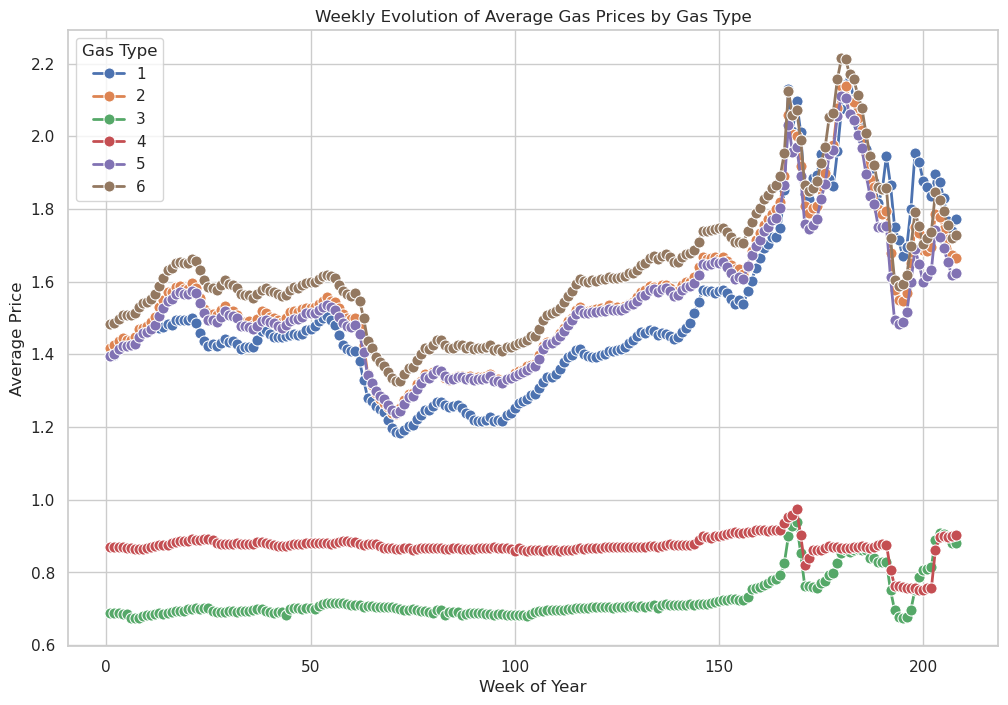

In [36]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = sorted_average_price_gas_type.toPandas()

# Initialize Seaborn
sns.set(style="whitegrid")

# Create a line plot for each gas type
plt.figure(figsize=(12, 8))
sns.lineplot(data=pandas_df, x="continuous_week_number", y="avg_price", hue="id_carburant", marker="o", markersize=8, linewidth=2)
plt.title("Weekly Evolution of Average Gas Prices by Gas Type")
plt.xlabel("Week of Year")
plt.ylabel("Average Price")
plt.legend(title="Gas Type")

# Show the plot
plt.show()

### Data Visualization Bonus
* Represent a map for each gas type of France geo heat maps of price indexes, for example at department level

## Modeling - Forecast next day price
* Build a model based on Spark ML to forecast the next day price for gas type in a station
(Do not consider using time series models but rely on existing techniques from Spark ML / MLLib such as LInearRegression, RandomForestRegressor
* Provide relevant accuracy measures and a relevant dispersion plot between actual and forecast


### Variables to be used in regression
* prix (number; gas price)
* latitude_adj and longitude_adj (number; station information)
* id_carburant (number; gas type)


In [37]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Imputer


In [38]:
prices_df_without_null_adj.printSchema()

root
 |-- id_pdv: string (nullable = true)
 |-- cp: string (nullable = true)
 |-- pop: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- id_carburant: string (nullable = true)
 |-- nom_carburant: string (nullable = true)
 |-- prix: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- WeekOfYear: integer (nullable = true)
 |-- continuous_week_number: integer (nullable = true)
 |-- latitude_int: integer (nullable = true)
 |-- longitude_int: integer (nullable = true)
 |-- prix_int: double (nullable = true)
 |-- latitude_adj: double (nullable = true)
 |-- longitude_adj: double (nullable = true)
 |-- prix_adj: double (nullable = true)



In [39]:
prices_df_without_null_adj.select("cp").distinct().count()

4348

In [40]:
prices_df_without_null_adj.select("pop").distinct().count()

3

In [41]:
# Population variable of type: string (needs to be indexed first then OHE)
op_pop = StringIndexer(inputCol = 'pop', outputCol = 'npop')
op_ohe_pop = OneHotEncoder(inputCol = 'npop', outputCol = 'ohepop')

op_features = VectorAssembler(inputCols = ['ohepop', 'latitude_adj', 'longitude_adj'],
                              outputCol= 'features')

pipeline_features = Pipeline(stages = [op_pop, op_ohe_pop, op_features])
pipeline_features.fit(prices_df_without_null_adj).transform(prices_df_without_null_adj).show(5, truncate = False)

+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+----------------------+------------+-------------+--------+------------+-------------+--------+----+-------------+----------------------------+---------------+
|id_pdv |cp   |pop|latitude|longitude|Date      |id_carburant|nom_carburant|prix|Year|Month|Day|WeekOfYear|continuous_week_number|latitude_int|longitude_int|prix_int|latitude_adj|longitude_adj|prix_adj|npop|ohepop       |features                    |prix_adj_vector|
+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+----------------------+------------+-------------+--------+------------+-------------+--------+----+-------------+----------------------------+---------------+
|1000001|01000|R  |4620114 |519791   |2019-01-04|1           |Gazole       |1328|2019|01   |04 |1         |1                     |4620114     |519791       |1328.0  |0.4620114   |0.519791     |1.328 

In [42]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor

rf = RandomForestRegressor(labelCol='prix_adj')
pipeline_rf = Pipeline(stages =[pipeline_features, rf])


In [43]:
fitted_rf = pipeline_rf.fit(prices_df_without_null_adj)
fitted_rf.transform(prices_df_without_null_adj).show(5, truncate=False)

24/01/19 17:33:50 WARN MemoryStore: Not enough space to cache rdd_436_4 in memory! (computed 61.6 MiB so far)
24/01/19 17:33:50 WARN BlockManager: Persisting block rdd_436_4 to disk instead.
24/01/19 17:33:52 WARN MemoryStore: Not enough space to cache rdd_436_3 in memory! (computed 92.5 MiB so far)
24/01/19 17:33:52 WARN BlockManager: Persisting block rdd_436_3 to disk instead.
24/01/19 17:33:52 WARN MemoryStore: Not enough space to cache rdd_436_0 in memory! (computed 92.5 MiB so far)
24/01/19 17:33:52 WARN BlockManager: Persisting block rdd_436_0 to disk instead.
24/01/19 17:33:53 WARN MemoryStore: Not enough space to cache rdd_436_1 in memory! (computed 92.5 MiB so far)
24/01/19 17:33:53 WARN BlockManager: Persisting block rdd_436_1 to disk instead.
24/01/19 17:34:07 WARN MemoryStore: Not enough space to cache rdd_436_2 in memory! (computed 328.8 MiB so far)
24/01/19 17:34:07 WARN BlockManager: Persisting block rdd_436_2 to disk instead.
24/01/19 17:34:20 WARN MemoryStore: Not enou

+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+----------------------+------------+-------------+--------+------------+-------------+--------+----+-------------+----------------------------+---------------+------------------+
|id_pdv |cp   |pop|latitude|longitude|Date      |id_carburant|nom_carburant|prix|Year|Month|Day|WeekOfYear|continuous_week_number|latitude_int|longitude_int|prix_int|latitude_adj|longitude_adj|prix_adj|npop|ohepop       |features                    |prix_adj_vector|prediction        |
+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+----------------------+------------+-------------+--------+------------+-------------+--------+----+-------------+----------------------------+---------------+------------------+
|1000001|01000|R  |4620114 |519791   |2019-01-04|1           |Gazole       |1328|2019|01   |04 |1         |1                     |4620114     

In [ ]:
fitted_rf.stages[-1]

In [ ]:
fitted_rf.transform(prices_df_without_null_adj).show(4)

In [ ]:
fitted_rf.stages[-1].coefficients